In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

2023-05-07 09:06:00.218601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 09:06:00.730390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-07 09:06:00.730407: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-07 09:06:01.821011: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-0

In [2]:
import matplotlib.pyplot as plt

In [396]:
csv_file = './va_temps.csv'
dataframe = pd.read_csv(csv_file)

In [397]:
dataframe = dataframe.drop(['Region', 'Country', 'State'], axis=1)

# leave just month
#dataframe = dataframe.drop(['City', 'Day', 'Year'], axis=1)

In [336]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Month,27795.0,6.468322,3.456911,1.0,3.0,6.0,9.0,12.0
AvgTemperature,27795.0,58.781194,17.474228,-99.0,46.1,60.4,73.3,93.5


In [398]:
temp_features = dataframe.copy()
temp_labels = temp_features.pop('AvgTemperature')

In [399]:
inputs = {}

# after this, try treating Year as a normalized numeric value rather than a category encoding

for name, column in temp_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.int64

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'City': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'City')>,
 'Month': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Month')>,
 'Day': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Day')>,
 'Year': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Year')>}

In [8]:
#inputs = {}
#inputs['City'] = tf.keras.Input(shape=(1,), name=name, dtype=tf.string)

In [402]:
#preprocessed_inputs = []

numeric_inputs = {name:input for name,input in inputs.items()
                  if input.name == 'Year'}
x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(dataframe[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

preprocessed_inputs = [all_numeric_inputs]

for name, input in inputs.items():
  if input.name == 'Year': continue
  if input.dtype == 'int64':
    lookup = layers.IntegerLookup(vocabulary=np.unique(temp_features[name]))
  else:
    lookup = layers.StringLookup(vocabulary=np.unique(temp_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

preprocessed_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_11')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_33')>,
 <KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'category_encoding_34')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'category_encoding_35')>]

In [401]:
# month only
preprocessed_inputs = []

for name, input in inputs.items():
  if input.name == 'Year': continue
  if input.dtype == 'int64':
    lookup = layers.IntegerLookup(vocabulary=np.unique(temp_features[name]))
  else:
    lookup = layers.StringLookup(vocabulary=np.unique(temp_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

preprocessed_inputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_30')>,
 <KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'category_encoding_31')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'category_encoding_32')>]

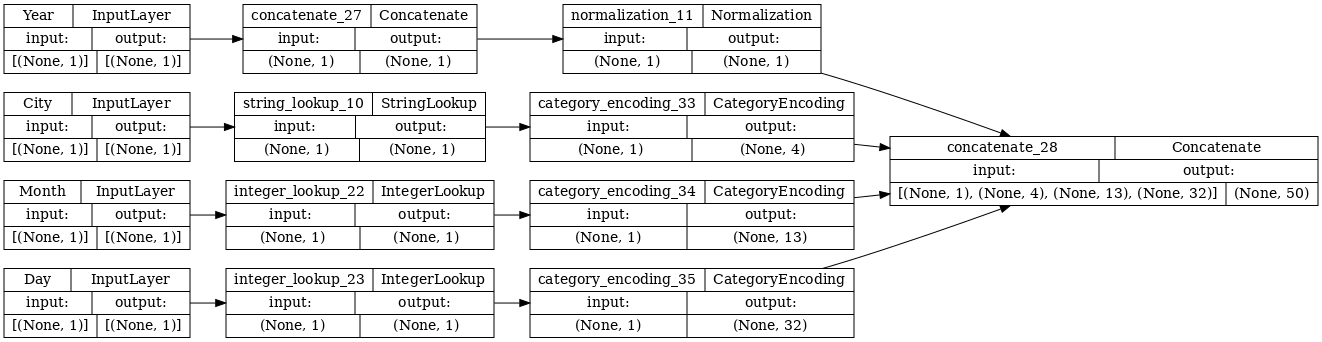

In [403]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
temp_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
tf.keras.utils.plot_model(model = temp_preprocessing, rankdir="LR", dpi=72, show_shapes=True)

In [404]:
temp_features_dict = {name: np.array(value) 
                         for name, value in temp_features.items()}

In [405]:
# just as a test, grab one row of features and run it through the preprocessing to see the shape output
features_dict = {name:values[:1] for name, values in temp_features_dict.items()}
temp_preprocessing(features_dict)

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[-1.6637644,  0.       ,  1.       ,  0.       ,  0.       ,
         0.       ,  1.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  1.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ]],
      dtype=float32)>

In [190]:
# DNN 
def create_temp_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

temp_model = create_temp_model(temp_preprocessing, inputs)

In [416]:
# linear 
def create_temp_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
  return model

temp_model = create_temp_model(temp_preprocessing, inputs)

In [417]:
history = temp_model.fit(x=temp_features_dict, y=temp_labels, epochs=10, validation_split = 0.2)

Epoch 1/10
695/695 [==============================] - 1s 1ms/step - loss: 8.7949 - val_loss: 6.8649
Epoch 2/10
695/695 [==============================] - 1s 1ms/step - loss: 6.6413 - val_loss: 6.3532
Epoch 3/10
695/695 [==============================] - 1s 1ms/step - loss: 6.6092 - val_loss: 6.2084
Epoch 4/10
695/695 [==============================] - 1s 962us/step - loss: 6.6186 - val_loss: 6.4379
Epoch 5/10
695/695 [==============================] - 1s 999us/step - loss: 6.5855 - val_loss: 6.1976
Epoch 6/10
695/695 [==============================] - 1s 1ms/step - loss: 6.6241 - val_loss: 6.1953
Epoch 7/10
695/695 [==============================] - 1s 1ms/step - loss: 6.5889 - val_loss: 6.2384
Epoch 8/10
695/695 [==============================] - 1s 1ms/step - loss: 6.6061 - val_loss: 6.2176
Epoch 9/10
695/695 [==============================] - 1s 904us/step - loss: 6.6389 - val_loss: 6.3376
Epoch 10/10
695/695 [==============================] - 1s 897us/step - loss: 6.5763 - val_loss

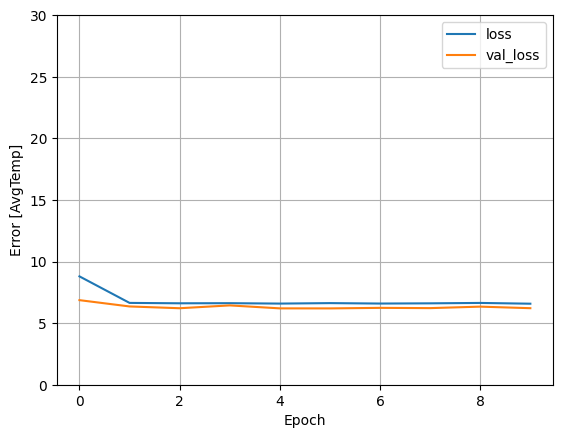

In [418]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 30])
  plt.xlabel('Epoch')
  plt.ylabel('Error [AvgTemp]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [419]:
# Predictions to compare to real

days_to_predict = 400
sample2 = {name:values[8768:8768+days_to_predict] for name, values in temp_features_dict.items()}

sample2['Year'] = np.array([2023 for a in range(days_to_predict)])

#print(type(temp_labels.array))

labels_2019 = temp_labels.array[8768-2:8768-2+days_to_predict]
#print(labels_2019)

# not really sure why these are 2 off ?
#labels_2018 = temp_labels.array[9133-2:9133-2+days_to_predict]
#print(labels_2018)


print(sample2)

predictions = temp_model.predict(sample2)

{'City': array(['Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk', 'Norfolk',
       'Norfolk', 'Norfolk', 'Norfolk', 'N

In [363]:
# Basic predictions

# Richmond,1,5,2008,36.6
sample = {
    'City': np.array(['Richmond'], dtype='object'),
    'Month': np.array([12]),
    'Day': np.array([20]),
    'Year': np.array([2022])
}

sample2 = {name:values[:10] for name, values in temp_features_dict.items()}

#print(sample)
#print(sample2)
#print(temp_features_dict)

predictions = temp_model.predict(sample2)
print(predictions)
# For Richmond,1,5,2008 it predicts 37 when the value was 36.6!
# For yesterday, 3 years beyond any data it has, in Richmond it predicts 67 when it was 53-75 - average: 64. Not bad!

1/1 [==============================] - 0s 9ms/step
[[38.225918]
 [38.225918]
 [38.225918]
 [38.225918]
 [38.225918]
 [38.225918]
 [38.225918]
 [38.225918]
 [38.225918]
 [38.225918]]


Next:
* Create a csv of dates from YTD 2023
* Get high/low or avg temps from YTD and put in csv
* Run predict on all of the 2023 dates
* Plot the predicted vs actual temps
* See how smart it is - does it shift depending on season?
    * Roughly it does seem to. But I'm curious how low it goes. Does it hover around the mean? Maybe that's the right thing
    * How would I encourage it to veer more wildly?

In [358]:
# load 2023 temps
csv_file_23 = './norfolk_temps_2023.csv'
dataframe_23 = pd.read_csv(csv_file_23)
dataframe_23.drop(['name', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'], axis=1)
#dataframe_23['datetime']= pd.to_datetime(dataframe_23['datetime'],format='%Y-%m-%d')
#dataframe_23['Day'] = dataframe_23['datetime'].dt.day
#dataframe_23['Month'] = dataframe_23['datetime'].dt.month
#dataframe_23['Year'] = dataframe_23['datetime'].dt.year

,datetime,temp
0,2023-01-01,55.8
1,2023-01-02,56.0
2,2023-01-03,61.6
3,2023-01-04,67.1
4,2023-01-05,60.3
...,...,...
124,2023-05-05,59.1
125,2023-05-06,62.6
126,2023-05-07,69.4
127,2023-05-08,74.0


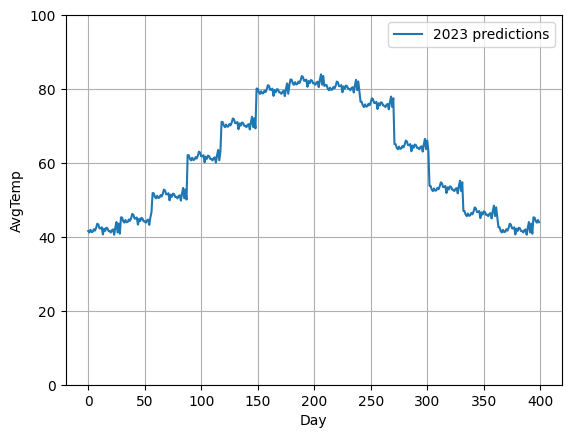

In [420]:
def plot_predictions():
  plt.plot(predictions, label='2023 predictions')
  #plt.plot(labels_2019, label='2019 actual')
  #plt.plot(dataframe_23['temp'], label='2023 actual')
  plt.ylim([0, 100])
  plt.xlabel('Day')
  plt.ylabel('AvgTemp')
  plt.legend()
  plt.grid(True)

plot_predictions()

In [394]:
weights = temp_model.get_weights()
#print(len(weights))
#print(weights[1])

for i in range(len(weights)):
    print(weights[i])
    print(weights[i].shape)
temp_model.summary()

[[ 0.14355636]
 [ 5.2409606 ]
 [ 8.380218  ]
 [15.96589   ]
 [25.258469  ]
 [33.30186   ]
 [42.234203  ]
 [45.695255  ]
 [44.61914   ]
 [38.566505  ]
 [28.563244  ]
 [16.659243  ]
 [ 9.713721  ]]
(13, 1)
[32.98496]
(1,)
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Month (InputLayer)          [(None, 1)]               0         
                                                                 
 model_34 (Functional)       (None, 13)                0         
                                                                 
 sequential_27 (Sequential)  (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
